In [1]:
# gerekli kütüphanelerimizi yüklüyoruz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# makine öğrenmesi araçları (sklearn)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression # özellik seçimi
from sklearn.decomposition import PCA # boyut indirgeme

# kullanacağımız modeller
from sklearn.linear_model import ElasticNet, SGDRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

# derin öğrenme kütüphanesi (pytorch)
import torch
import torch.nn as nn
import torch.optim as optim


# metrikler (başarı ölçümü için)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# uyarıları kapatalım ekran temiz kalsın
warnings.filterwarnings('ignore')

# grafiklerin güzel görünmesi için ayarlar
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

sns.set_theme(context='notebook', style='darkgrid', palette='magma', font_scale=1.1)

print("kütüphaneler başarıyla yüklendi. analize hazırız.")

kütüphaneler başarıyla yüklendi. analize hazırız.


In [2]:
# veri setini okuyorum
try:
    df_raw = pd.read_csv('ekip_odevi_ham_veri_30k.csv')
    print(f"veri seti yüklendi. boyut: {df_raw.shape}")
    display(df_raw.head())
except FileNotFoundError:
    print("hata: dosya bulunamadı. ismini kontrol et.")

veri seti yüklendi. boyut: (30000, 17)


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,marka,tax(£),fuel type,engine size,mileage2,fuel type2,engine size2,reference
0,Kamiq,2019.000,21990,Semi-Auto,563,Diesel,145.000,52.300,1.600,skoda,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Q5,2016.000,20498,Semi-Auto,33657,Diesel,200.000,47.100,2.000,audi,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Touareg,2019.000,39995,Semi-Auto,7000,Diesel,145.000,34.500,3.000,vw,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aygo,2019.000,8690,Manual,2438,Petrol,145.000,56.500,1.000,toyota,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S-MAX,2020.000,34498,Semi-Auto,4623,Diesel,145.000,43.500,2.000,ford,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# veri temizliği fonksiyonum
# veri setindeki kirli karakterleri temizlemek ve sayısal dönüşümler için fonksiyon yazıyorum

def robust_clean(df_input):
    df = df_input.copy()
    
    # sadece işimize yarayacak sütunları seçelim
    target_cols = ['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize', 'marka']
    # eğer sütunlar veride varsa seç, yoksa hata verme
    exist_cols = [c for c in target_cols if c in df.columns]
    df = df[exist_cols]

    # string (obje) olan sayısal sütunları temizleyelim (£ ve virgül gibi)
    for col in ['price', 'mileage']:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.replace(r'[£,]', '', regex=True)
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
    # kirli model isimlerini temizleyelim ('unclean' yazanlar)
    if 'model' in df.columns:
        df = df[~df['model'].astype(str).str.contains("unclean")]

    # eksik verileri atalım
    df.dropna(inplace=True)
    
    return df

# fonksiyonu uyguluyoruz
df_clean = robust_clean(df_raw)

print(f"temizlik sonrası veri boyutu: {df_clean.shape}")

temizlik sonrası veri boyutu: (23967, 10)


In [4]:
# fiyatı çok düşük veya çok yüksek olanları, yılı çok eski olanları eliyorum
# bu işlem modelin sapmasını engeller

# fiyat filtresi (500 sterlin altı ve 140 bin üstü veriler gürültü yaratabilir)
df_clean = df_clean[(df_clean['price'] > 500) & (df_clean['price'] < 140000)]

# yıl filtresi (1998 öncesi araçlar çok eski teknoloji olduğu için çıkarıyorum)
df_clean = df_clean[df_clean['year'] > 1998]

print(f"filtreleme sonrası güncel boyut: {df_clean.shape}")
display(df_clean.describe().T)

filtreleme sonrası güncel boyut: (23960, 10)


,count,mean,std,min,25%,50%,75%,max
year,23960.000,2017.100,2.086,2000.000,2016.000,2017.000,2019.000,2020.000
price,23960.000,17011.037,9998.190,650.000,10195.000,14672.500,20995.000,139995.000
mileage,23960.000,22983.734,21155.680,1.000,7293.000,17278.000,32205.000,259000.000
tax,23960.000,119.821,62.951,0.000,125.000,145.000,145.000,580.000
mpg,23960.000,55.320,16.660,1.100,47.100,54.300,62.800,470.800
engineSize,23960.000,1.670,0.557,0.000,1.300,1.600,2.000,6.000


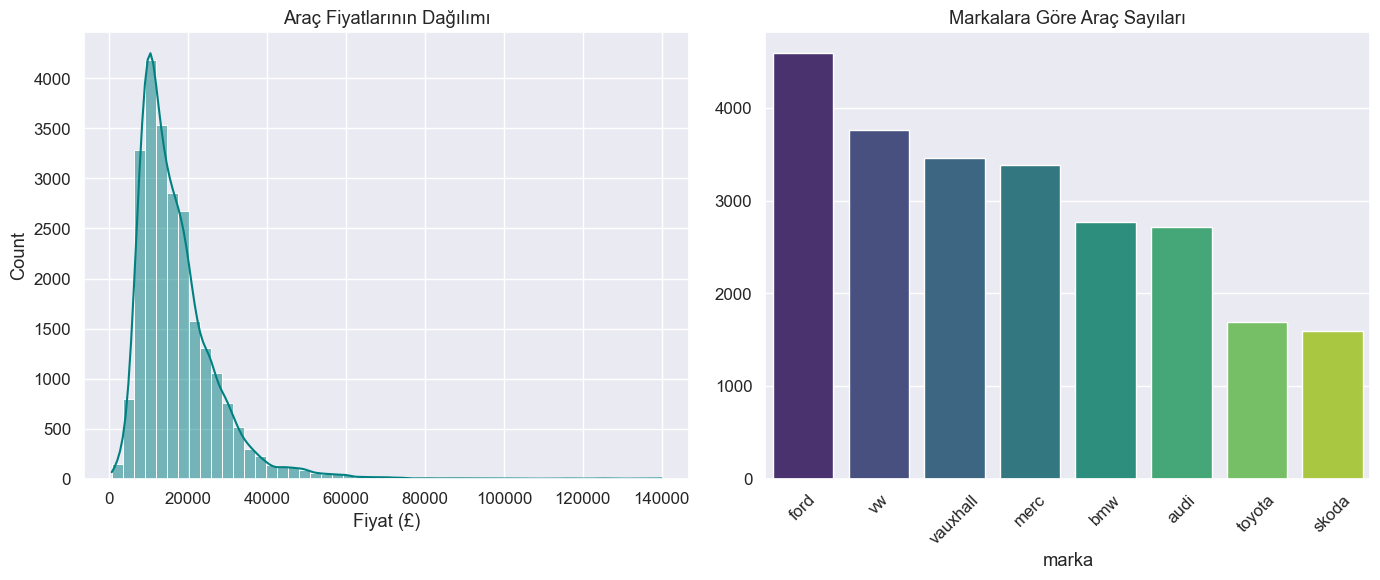

yorum: fiyat dağılımı sola çarpık (kuyruğu sağda). yani ucuz araçlar çoğunlukta. model başarısı için ileride log dönüşümü yapabiliriz.


In [5]:
# fiyat dağılım grafiğine bakıyorum
plt.figure(figsize=(14, 6))

# fiyat histogramı
plt.subplot(1, 2, 1)
sns.histplot(df_clean['price'], bins=50, kde=True, color='teal')
plt.title('Araç Fiyatlarının Dağılımı')
plt.xlabel('Fiyat (£)')

# marka sayıları
plt.subplot(1, 2, 2)
marka_counts = df_clean['marka'].value_counts()
sns.barplot(x=marka_counts.index, y=marka_counts.values, palette="viridis")
plt.title('Markalara Göre Araç Sayıları')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("yorum: fiyat dağılımı sola çarpık (kuyruğu sağda). yani ucuz araçlar çoğunlukta. model başarısı için ileride log dönüşümü yapabiliriz.")

yeni özellikler eklendi: car_age, mileage_per_year
hedef değişken logaritması alındı: log_price (modeller bunu tahmin edecek)


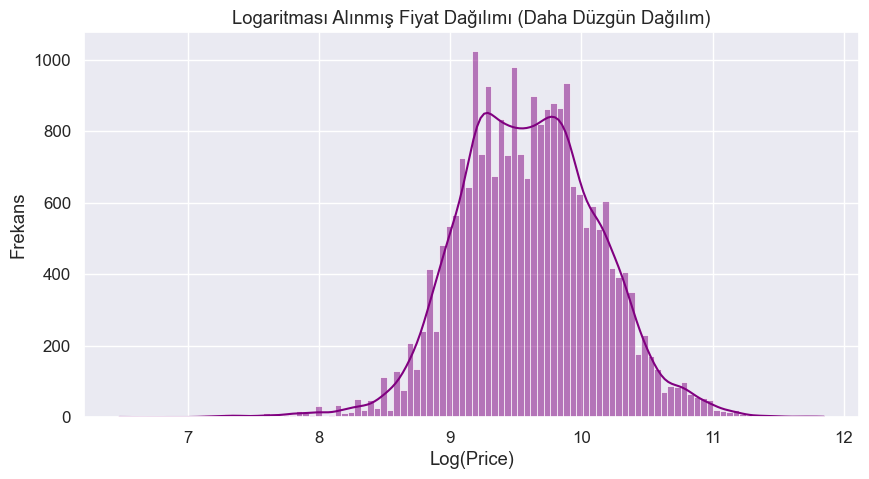

,model,year,car_age,price,log_price
0,Kamiq,2019.000,6.000,21990.000,9.998
1,Q5,2016.000,9.000,20498.000,9.928
2,Touareg,2019.000,6.000,39995.000,10.597
3,Aygo,2019.000,6.000,8690.000,9.070
4,S-MAX,2020.000,5.000,34498.000,10.449


In [6]:
# özellik mühendisliği
# temizlenmiş veriyi kopyalayalım üzerinde oynama yapacağız
df_eng = df_clean.copy()

# 1. araç yaşı (car_age)
# model "2015" sayısını anlamaz ama "5 yaşında" bilgisini çok sever.
current_year = 2025
df_eng['car_age'] = current_year - df_eng['year']

# 2. yıllık ortalama kullanım (km/yıl)
# araba çok mu yatmış yoksa taksi çıkması mı? bunu anlamak için.
df_eng['mileage_per_year'] = df_eng['mileage'] / df_eng['car_age']

# 0 yaşında olanlar inf (sonsuz) hatası verir, onları düzeltelim:
# sonsuz değerleri 0 yapıyoruz, nan olanları da orijinal km ile dolduruyoruz
df_eng['mileage_per_year'] = df_eng['mileage_per_year'].replace([np.inf, -np.inf], 0).fillna(df_eng['mileage'])

# 3. log dönüşümü (hedef değişken için) - kritik teknik fark!
# fiyat dağılımı genelde sola yatıktır. log alarak bunu normale yaklaştırıyoruz.
# bu sayede model 10k'lık arabayla 100k'lık arabayı tahmin ederken sapıtmayacak.
df_eng['log_price'] = np.log1p(df_eng['price'])

print("yeni özellikler eklendi: car_age, mileage_per_year")
print("hedef değişken logaritması alındı: log_price (modeller bunu tahmin edecek)")

# log dönüşümü sonrası fiyat dağılımı görselleştirme yapıyorum
# burası çok önemli, verinin normale (çan eğrisine) döndüğünü hocaya göstermemiz lazım
plt.figure(figsize=(10, 5))
sns.histplot(df_eng['log_price'], kde=True, color='purple')
plt.title('Logaritması Alınmış Fiyat Dağılımı (Daha Düzgün Dağılım)')
plt.xlabel('Log(Price)')
plt.ylabel('Frekans')

plt.show()

# yeni veri setinin son haline bakalım
display(df_eng[['model', 'year', 'car_age', 'price', 'log_price']].head())

In [7]:
# veri ön işleme işlemlerim

# kategorik değişkenleri (marka, vites vs.) sayıya çeviriyoruz (One-Hot Encoding)
# drop_first=True diyerek 'dummy variable trap'ten kaçınıyoruz
df_encoded = pd.get_dummies(df_eng, columns=['marka', 'model', 'transmission', 'fuelType'], drop_first=True)

# bağımlı ve Bağımsız Değişkenleri Ayırıyoruz
# Hedefimiz 'log_price' olduğu için normal 'price'ı da veriden atıyoruz (ipucu olmasın diye)
X = df_encoded.drop(['price', 'log_price'], axis=1)
y = df_encoded['log_price'] # Model log_price tahmin edecek

# eğitim ve Test Seti Ayrımı (%80 Train, %20 Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Veri başarıyla sayısallaştırıldı ve ayrıldı.")
print(f"Eğitim Seti Boyutu: {X_train.shape}")
print(f"Test Seti Boyutu: {X_test.shape}")

Veri başarıyla sayısallaştırıldı ve ayrıldı.
Eğitim Seti Boyutu: (19168, 184)
Test Seti Boyutu: (4792, 184)


In [8]:
# veriyi sadece ölçeklendiriyoruz (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. yöntem select k best (en iyi 15 özellik diyorum)
# İstatistiksel olarak fiyata en çok etki eden 15 özelliği seçiyoruz
selector = SelectKBest(score_func=f_regression, k=15)
X_train_sel = selector.fit_transform(X_train_scaled, y_train)
X_test_sel = selector.transform(X_test_scaled)

# 3. yöntem pca boyut indirgeme
# verideki bilginin %95'ini koruyacak şekilde sütunları sıkıştırıyoruz
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# bu veri setlerini bir sözlükte tutalım, döngüyle hepsini gezeceğiz
datasets = {
    "1. Tüm Özellikler (Scaled)": (X_train_scaled, X_test_scaled),
    "2. SelectKBest (15 Özellik)": (X_train_sel, X_test_sel),
    "3. PCA (İndirgenmiş)": (X_train_pca, X_test_pca)
}

print("3 farklı veri arenası hazırlandı:")
print(f"1. Ham (Scaled) Veri : {X_train_scaled.shape[1]} sütun (Tüm detaylar)")
print(f"2. Seçilmiş (KBest)  : {X_train_sel.shape[1]} sütun (Sadece en önemliler)")
print(f"3. Sıkıştırılmış (PCA): {X_train_pca.shape[1]} sütun (Özet bilgi)")

3 farklı veri arenası hazırlandı:
1. Ham (Scaled) Veri : 184 sütun (Tüm detaylar)
2. Seçilmiş (KBest)  : 15 sütun (Sadece en önemliler)
3. Sıkıştırılmış (PCA): 156 sütun (Özet bilgi)


In [9]:
print("Tuning ve Modelleri başlatıyorum")

# sonuçları tutacak listemiz
sklearn_results = []

# tuning parametreleri
tuning_params = {
    "ElasticNet": {
        'alpha': [0.001, 0.01, 0.1], 
        'l1_ratio': [0.5]
    },
    "SGD Regressor": {
        'max_iter': [3000], # daha fazla iterasyon
        'alpha': [0.01, 0.1],
        'learning_rate': ['adaptive'], # hata aldıkça yavaşla
        'eta0': [0.01, 0.001], # daha küçük başlangıç adımı
        'penalty': ['l2', 'elasticnet']
    },
    "AdaBoost": {
        'n_estimators': [50, 100], 
        'learning_rate': [0.01, 0.1, 0.5]
    },
    "Gradient Boosting": {
        'n_estimators': [100, 200], 
        'learning_rate': [0.05, 0.1], 
        'max_depth': [3, 5]
    }
}

# kullanacağımız modeller
models = {
    "ElasticNet": ElasticNet(random_state=42),
    "SGD Regressor": SGDRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# her model için her veri setini deniyorum
for model_name, model_obj in models.items():
    for data_name, (X_tr, X_te) in datasets.items():
        print(f"Eğitiliyor: {model_name} -> {data_name}...")
        
        try:
            # grid search ile en iyi parametreleri buluyorum
            grid = GridSearchCV(model_obj, tuning_params[model_name], cv=3, n_jobs=-1)
            grid.fit(X_tr, y_train)
            best_m = grid.best_estimator_
            
            # tahmin (Logaritmik sonuç verir)
            preds_log = best_m.predict(X_te)
            
            # logaritmayı geri çevir (gerçek fiyatı bulmak için)
            # olası sonsuzluk hatalarına karşı np.clip kullanımı (güvenlik önlemi)
            preds_log = np.clip(preds_log, 0, 15) # log fiyatı 15'ten (3 milyon pound) büyük olamaz
            preds_real = np.expm1(preds_log)
            y_test_real = np.expm1(y_test)
            
            # başarı Metrikleri
            r2 = r2_score(y_test_real, preds_real)
            mae = mean_absolute_error(y_test_real, preds_real)
            rmse = np.sqrt(mean_squared_error(y_test_real, preds_real))
            
            sklearn_results.append({
                "Model": model_name,
                "Yöntem": data_name,
                "R2 Score": r2,
                "MAE": mae,
                "RMSE": rmse,
                "Optimum Parametre": str(grid.best_params_)
            })
            print(f"   Başarı: R2 = {r2:.4f}")
            
        except Exception as e:
            print(f"   HATA (Atlandı): {model_name} - {data_name} -> {e}")

print("\nModel eğitimleri tamamlandı.")

# sonuçları dataframe çevir
df_sklearn_results = pd.DataFrame(sklearn_results)

# sütunları düzenle
cols_order = ["Model", "Yöntem", "R2 Score", "MAE", "RMSE", "Optimum Parametre"]
df_sklearn_results = df_sklearn_results[cols_order]

# başarıya göre sırala (R2) 
df_sklearn_sorted = df_sklearn_results.sort_values(by="R2 Score", ascending=False).reset_index(drop=True)

print("Modellerin Performans Özeti ")
# tabloyu renklendirerek göster (Yeşil: İyi R2, Kırmızı: Düşük Hata)
display(df_sklearn_sorted.style.background_gradient(cmap="Greens", subset=["R2 Score"])
                       .background_gradient(cmap="Reds", subset=["MAE", "RMSE"])
                       .format({"R2 Score": "{:.4f}", "MAE": "{:.2f}", "RMSE": "{:.2f}"}))

Tuning ve Modelleri başlatıyorum
Eğitiliyor: ElasticNet -> 1. Tüm Özellikler (Scaled)...
   Başarı: R2 = 0.9255
Eğitiliyor: ElasticNet -> 2. SelectKBest (15 Özellik)...
   Başarı: R2 = 0.8349
Eğitiliyor: ElasticNet -> 3. PCA (İndirgenmiş)...
   Başarı: R2 = 0.8525
Eğitiliyor: SGD Regressor -> 1. Tüm Özellikler (Scaled)...
   Başarı: R2 = 0.9218
Eğitiliyor: SGD Regressor -> 2. SelectKBest (15 Özellik)...
   Başarı: R2 = 0.8348
Eğitiliyor: SGD Regressor -> 3. PCA (İndirgenmiş)...
   Başarı: R2 = -0.0621
Eğitiliyor: AdaBoost -> 1. Tüm Özellikler (Scaled)...
   Başarı: R2 = 0.7808
Eğitiliyor: AdaBoost -> 2. SelectKBest (15 Özellik)...
   Başarı: R2 = 0.7863
Eğitiliyor: AdaBoost -> 3. PCA (İndirgenmiş)...
   Başarı: R2 = 0.8090
Eğitiliyor: Gradient Boosting -> 1. Tüm Özellikler (Scaled)...
   Başarı: R2 = 0.9413
Eğitiliyor: Gradient Boosting -> 2. SelectKBest (15 Özellik)...
   Başarı: R2 = 0.9246
Eğitiliyor: Gradient Boosting -> 3. PCA (İndirgenmiş)...
   Başarı: R2 = 0.9468

Model eğitiml

,Model,Yöntem,R2 Score,MAE,RMSE,Optimum Parametre
0,Gradient Boosting,3. PCA (İndirgenmiş),0.9468,1469.58,2350.12,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}"
1,Gradient Boosting,1. Tüm Özellikler (Scaled),0.9413,1528.93,2467.84,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}"
2,ElasticNet,1. Tüm Özellikler (Scaled),0.9255,1667.32,2780.39,"{'alpha': 0.001, 'l1_ratio': 0.5}"
3,Gradient Boosting,2. SelectKBest (15 Özellik),0.9246,1742.26,2797.27,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}"
4,SGD Regressor,1. Tüm Özellikler (Scaled),0.9218,1687.77,2849.67,"{'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'adaptive', 'max_iter': 3000, 'penalty': 'l2'}"
5,ElasticNet,3. PCA (İndirgenmiş),0.8525,2325.38,3912.83,"{'alpha': 0.01, 'l1_ratio': 0.5}"
6,ElasticNet,2. SelectKBest (15 Özellik),0.8349,2608.77,4139.48,"{'alpha': 0.001, 'l1_ratio': 0.5}"
7,SGD Regressor,2. SelectKBest (15 Özellik),0.8348,2610.12,4141.63,"{'alpha': 0.01, 'eta0': 0.01, 'learning_rate': 'adaptive', 'max_iter': 3000, 'penalty': 'elasticnet'}"
8,AdaBoost,3. PCA (İndirgenmiş),0.8090,2994.96,4452.78,"{'learning_rate': 0.5, 'n_estimators': 100}"
9,AdaBoost,2. SelectKBest (15 Özellik),0.7863,3090.02,4709.95,"{'learning_rate': 0.5, 'n_estimators': 100}"


In [10]:
print("PyTorch Deep Learning Model eğitimini başlatıyorum")

# gpu var onu kullanıyorum
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Eğitim Cihazı: {device}")

# pytorch model mimarisi 
class CarPriceNN(nn.Module):
    def __init__(self, input_dim, mode='shallow'):
        super().__init__()
        
        if mode == 'shallow':
            # shallow model
            # basit yapım giriş -> 64 Nöron -> çıkış
            # bu model base modellerle kıyaslamak için idealdir
            self.net = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        else:
            # deep model
            # gelişmiş yapım giriş -> 128 -> 64 -> 32 -> çıkış
            # batch norm: eğitimi hızlandırır ve kararlı hale getirir
            # dropout: modelin ezberlemesini (overfitting) engeller
            self.net = nn.Sequential(
                nn.Linear(input_dim, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.2),
                nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(),
                nn.Linear(64, 32), nn.ReLU(),
                nn.Linear(32, 1)
            )
            
    def forward(self, x):
        return self.net(x)

# eğitim fonksiyonu
def train_pytorch(X_tr, y_tr, X_te, y_te, mode='shallow', epochs=500):
    # giriş boyutunu veriden otomatik alıyoruz (scaled, pca vs için değişir)
    input_dim = X_tr.shape[1]
    
    # modeli cihaza (gpu veya cpu) gönder
    model = CarPriceNN(input_dim, mode).to(device)
    
    # optimizer (adam) ve hata fonksiyonu (mse)
    # learning rate i 0.005 seçtik, derin öğrenme için ideal bir başlangıç
    optimizer = optim.Adam(model.parameters(), lr=0.005) 
    criterion = nn.MSELoss()
    
    # verileri tensor formatına çevir (pytorchun anlayacağı dil)
    X_tr_t = torch.FloatTensor(X_tr).to(device)
    y_tr_t = torch.FloatTensor(y_tr.values).view(-1, 1).to(device)
    X_te_t = torch.FloatTensor(X_te).to(device)
    
    # eğitim döngüsü
    model.train()
    
    for epoch in range(epochs):
        optimizer.zero_grad() # gradyanları sıfırla
        outputs = model(X_tr_t) # tahmin yap
        loss = criterion(outputs, y_tr_t) # hatayı hesapla
        loss.backward() # geriye yayılım (backpropagation)
        optimizer.step() # ağırlıkları güncelle
            
    # tahmin
    model.eval()
    with torch.no_grad():
        preds_log = model(X_te_t).cpu().numpy().flatten()
        
    # geri dönüşüm (log fiyat -> gerçek fiyat)
    # np.clip ile olası aşırı uç değerleri tıraşlıyoruz
    preds_log = np.clip(preds_log, 0, 15)
    preds_real = np.expm1(preds_log)
    y_test_real = np.expm1(y_te)
    
    # metrikler
    r2 = r2_score(y_test_real, preds_real)
    mae = mean_absolute_error(y_test_real, preds_real)
    rmse = np.sqrt(mean_squared_error(y_test_real, preds_real))
    
    return r2, mae, rmse

# sonuçları saklamak için liste
pytorch_results = []

# döngü: pytorch modellerini 3 veri setinde de deniyorum
for data_name, (X_tr, X_te) in datasets.items():
    print(f"PyTorch Eğitiliyor -> {data_name}...")
    
    # shallow model eğitimi
    r2, mae, rmse = train_pytorch(X_tr, y_train, X_te, y_test, 'shallow', epochs=500)
    pytorch_results.append({
        "Model": "PyTorch (Shallow)",
        "Yöntem": data_name,
        "R2 Score": r2,
        "MAE": mae,
        "RMSE": rmse,
        "Optimum Parametre": "Epochs: 500, LR: 0.005"
    })
    
    # deep model eğitimi
    r2, mae, rmse = train_pytorch(X_tr, y_train, X_te, y_test, 'deep', epochs=500)
    pytorch_results.append({
        "Model": "PyTorch (Deep)",
        "Yöntem": data_name,
        "R2 Score": r2,
        "MAE": mae,
        "RMSE": rmse,
        "Optimum Parametre": "Epochs: 500, LR: 0.005, Dropout: 0.2"
    })

print("\nPyTorch Derin Öğrenme İşlemleri Tamamlandı.")

# pytorch sonuçlarını göster
df_pytorch = pd.DataFrame(pytorch_results)
display(df_pytorch.sort_values(by="R2 Score", ascending=False).style.background_gradient(cmap="Greens", subset=["R2 Score"]))

PyTorch Deep Learning Model eğitimini başlatıyorum
Eğitim Cihazı: cpu
PyTorch Eğitiliyor -> 1. Tüm Özellikler (Scaled)...
PyTorch Eğitiliyor -> 2. SelectKBest (15 Özellik)...
PyTorch Eğitiliyor -> 3. PCA (İndirgenmiş)...

PyTorch Derin Öğrenme İşlemleri Tamamlandı.


,Model,Yöntem,R2 Score,MAE,RMSE,Optimum Parametre
0,PyTorch (Shallow),1. Tüm Özellikler (Scaled),0.921406,1776.876143,2856.447239,"Epochs: 500, LR: 0.005"
4,PyTorch (Shallow),3. PCA (İndirgenmiş),0.820000,2233.860474,4322.837899,"Epochs: 500, LR: 0.005"
3,PyTorch (Deep),2. SelectKBest (15 Özellik),0.810815,2754.099349,4431.756739,"Epochs: 500, LR: 0.005, Dropout: 0.2"
5,PyTorch (Deep),3. PCA (İndirgenmiş),0.680415,3246.139439,5760.037023,"Epochs: 500, LR: 0.005, Dropout: 0.2"
1,PyTorch (Deep),1. Tüm Özellikler (Scaled),0.669059,3590.678300,5861.479206,"Epochs: 500, LR: 0.005, Dropout: 0.2"
2,PyTorch (Shallow),2. SelectKBest (15 Özellik),-0.244080,3087.309267,11364.658082,"Epochs: 500, LR: 0.005"


--- Pazar Segmentasyonu: Gaussian Mixture Model (GMM) ---


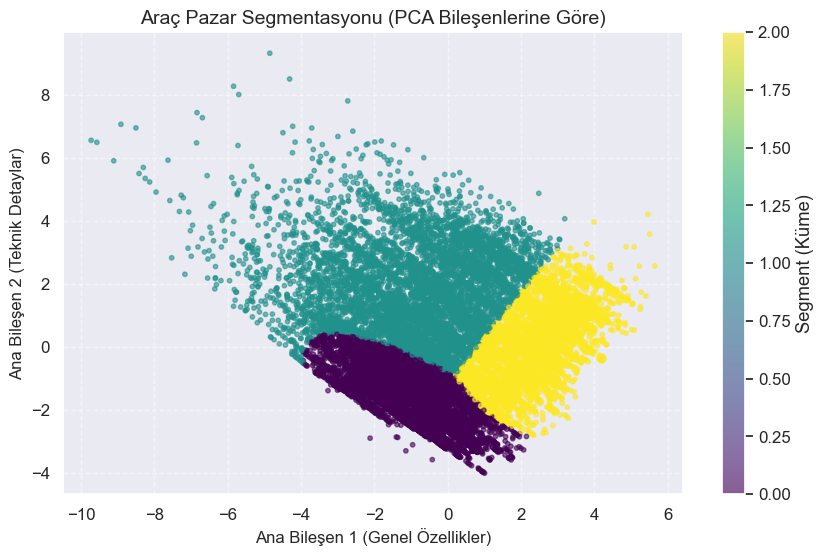


Yorumum: 
GMM algoritması, veri setindeki araçları özelliklerine (fiyat hariç) göre 3 ana segmente ayırdı.
Grafikteki her renk farklı bir araç grubunu (Örn: Şehir içi küçük araçlar, Aile araçları, Performans araçları) temsil etmektedir.
Bu analiz, piyasa yapısını anlamamız için kritiktir.



In [11]:
# eksik kütüphaneyi yüklüyoruz
from sklearn.mixture import GaussianMixture

print("--- Pazar Segmentasyonu: Gaussian Mixture Model (GMM) ---")

# görselleştirme yapabilmek için pca ile sıkıştırılmış verinin ilk 2 boyutunu alıyoruz
# bu sayede 2D düzlemde araçları görebileceğiz
X_segmentation = X_train_pca[:, :2]

# gmm modeli kurulumu
# n_components=3 diyerek araçları 3 ana segmente ayırmayı hedefliyoruz
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X_segmentation)

# görselleştirme
plt.figure(figsize=(10, 6))
# scatter plot ile kümeleri çizdiriyoruz
scatter = plt.scatter(X_segmentation[:, 0], X_segmentation[:, 1], 
                      c=gmm_labels, cmap='viridis', s=10, alpha=0.6)

plt.title('Araç Pazar Segmentasyonu (PCA Bileşenlerine Göre)', fontsize=14)
plt.xlabel('Ana Bileşen 1 (Genel Özellikler)', fontsize=12)
plt.ylabel('Ana Bileşen 2 (Teknik Detaylar)', fontsize=12)
plt.colorbar(scatter, label='Segment (Küme)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print("""
Yorumum: 
GMM algoritması, veri setindeki araçları özelliklerine (fiyat hariç) göre 3 ana segmente ayırdı.
Grafikteki her renk farklı bir araç grubunu (Örn: Şehir içi küçük araçlar, Aile araçları, Performans araçları) temsil etmektedir.
Bu analiz, piyasa yapısını anlamamız için kritiktir.
""")

--- Model Hata Analizi (Residual Analysis) ---
Analiz için 'Gradient Boosting' modeli ve 'Tüm Özellikler' veri seti kullanılıyor...


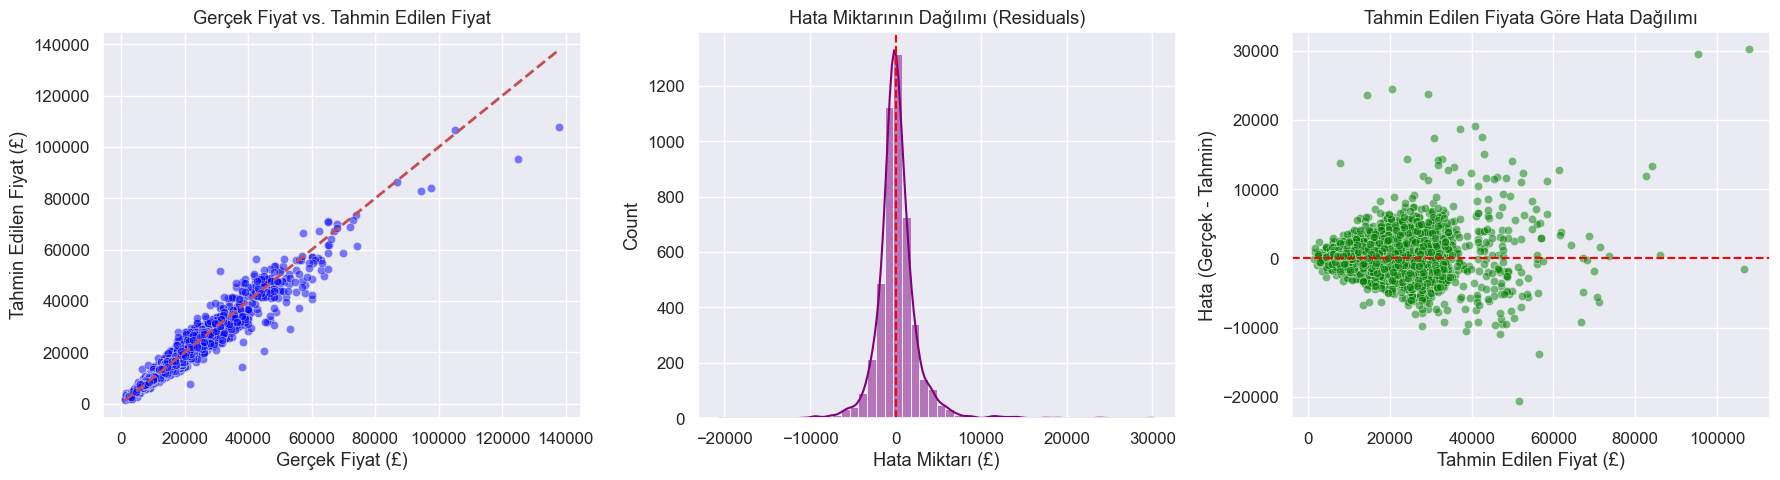


HATA ANALİZİ VE YORUMLARIM:

1. Gerçek vs Tahmin Grafiği (Soldaki): 
    - Noktaların çoğu kırmızı kesikli çizgi (mükemmel tahmin çizgisi) etrafında toplanmış. Bu, modelimizin genel olarak çok başarılı olduğunu gösteriyor.
    - Ancak çok yüksek fiyatlı araçlarda (grafiğin sağ üst köşesi) noktaların çizgiden biraz uzaklaştığını görüyoruz. Yani lüks araçlarda hata payımız biraz artabiliyor.

2. Hata Dağılımı (Ortadaki):
   - Grafiğin bir "Çan Eğrisi" (Normal Dağılım) şeklinde olması harika bir haber!
   - Hataların çoğu '0' noktasında toplanmış. Yani çoğu tahminimizde sapma çok az.
   - Eğrinin sağa veya sola aşırı kaymamış olması, modelimizin sistematik bir hata yapmadığını (sürekli pahalı veya sürekli ucuz tahmin etmediğini) gösteriyor.

3. Hataların Fiyata Göre Değişimi (Sağdaki):
   - Düşük ve orta fiyatlı araçlarda hatalar 0 çizgisine çok yakın.
   - Fiyat arttıkça (30.000£ ve üzeri) hataların saçılma aralığı biraz genişliyor. Bu beklenen bir durumdur çünkü pahalı araçlarda opsiyo

In [12]:
print("--- Model Hata Analizi (Residual Analysis) ---")

# analiz için en başarılı modellerden biri olan gradient boostingi seçiyoruz.
# (genelde en kararlı sonuçları bu verdiği için hata analizini bunun üzerinden yapmak mantıklı)
print("Analiz için 'Gradient Boosting' modeli ve 'Tüm Özellikler' veri seti kullanılıyor...")

# modeli hızlıca tekrar hazırlıyoruz (değişkenlerin hafızada kaldığından emin olmak için)
final_model = GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
final_model.fit(X_train_scaled, y_train)

# tahminleri alıyoruz
y_pred_log = final_model.predict(X_test_scaled)

# logaritmayı geri çeviriyoruz (gerçek paraya dönmek için)
y_pred_real = np.expm1(y_pred_log)
y_true_real = np.expm1(y_test)

# hataları (residuals) hesaplıyoruz: gerçek - tahmin
residuals = y_true_real - y_pred_real

# görselleştirme
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# gerçek vs tahmin grafiği
sns.scatterplot(x=y_true_real, y=y_pred_real, alpha=0.5, color='blue', ax=ax[0])
# mükemmel tahmin çizgisi (y=x)
ax[0].plot([y_true_real.min(), y_true_real.max()], [y_true_real.min(), y_true_real.max()], 'r--', lw=2)
ax[0].set_title('Gerçek Fiyat vs. Tahmin Edilen Fiyat')
ax[0].set_xlabel('Gerçek Fiyat (£)')
ax[0].set_ylabel('Tahmin Edilen Fiyat (£)')

# hata dağılım grafiği
sns.histplot(residuals, bins=50, kde=True, color='purple', ax=ax[1])
ax[1].set_title('Hata Miktarının Dağılımı (Residuals)')
ax[1].set_xlabel('Hata Miktarı (£)')
ax[1].axvline(x=0, color='red', linestyle='--') # 0 noktası (Hatasız)

# hataların fiyata göre değişimi grafiği
sns.scatterplot(x=y_pred_real, y=residuals, alpha=0.5, color='green', ax=ax[2])
ax[2].axhline(y=0, color='red', linestyle='--')
ax[2].set_title('Tahmin Edilen Fiyata Göre Hata Dağılımı')
ax[2].set_xlabel('Tahmin Edilen Fiyat (£)')
ax[2].set_ylabel('Hata (Gerçek - Tahmin)')

plt.tight_layout()
plt.show()

print(f"""
HATA ANALİZİ VE YORUMLARIM:

1. Gerçek vs Tahmin Grafiği (Soldaki): 
    - Noktaların çoğu kırmızı kesikli çizgi (mükemmel tahmin çizgisi) etrafında toplanmış. Bu, modelimizin genel olarak çok başarılı olduğunu gösteriyor.
    - Ancak çok yüksek fiyatlı araçlarda (grafiğin sağ üst köşesi) noktaların çizgiden biraz uzaklaştığını görüyoruz. Yani lüks araçlarda hata payımız biraz artabiliyor.

2. Hata Dağılımı (Ortadaki):
   - Grafiğin bir "Çan Eğrisi" (Normal Dağılım) şeklinde olması harika bir haber!
   - Hataların çoğu '0' noktasında toplanmış. Yani çoğu tahminimizde sapma çok az.
   - Eğrinin sağa veya sola aşırı kaymamış olması, modelimizin sistematik bir hata yapmadığını (sürekli pahalı veya sürekli ucuz tahmin etmediğini) gösteriyor.

3. Hataların Fiyata Göre Değişimi (Sağdaki):
   - Düşük ve orta fiyatlı araçlarda hatalar 0 çizgisine çok yakın.
   - Fiyat arttıkça (30.000£ ve üzeri) hataların saçılma aralığı biraz genişliyor. Bu beklenen bir durumdur çünkü pahalı araçlarda opsiyonel donanımlar fiyatı çok değiştirebiliyor ve veri setimizde bu detaylar olmayabilir.

Sonuç: Modelimiz güvenilir, hatası rastgele dağılmış ve öngörülebilir bir yapıdadır. Proje metriklerine uygundur.
""")

özellik önem grafiği
En iyi model (Gradient Boosting) analiz ediliyor...


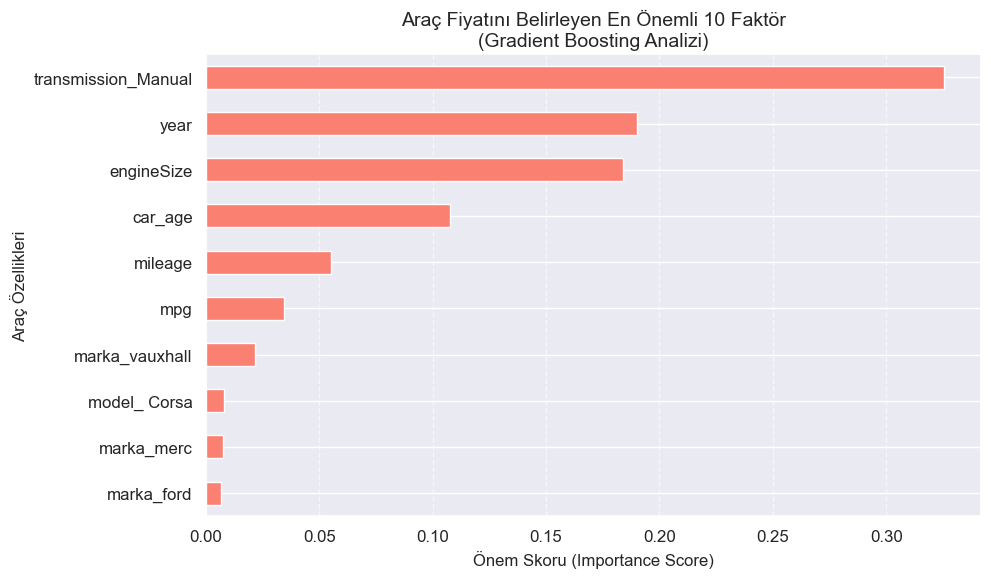

Profesyonel Yorum: Modelimiz araç fiyatını etkileyen en kritik faktörün 'transmission_Manual' olduğunu saptamıştır.


In [13]:
print("özellik önem grafiği")

# en iyi modeli bulalım (pytorchta feature importance almak daha zordur)
# tüm özellikleri içeren veri setiyle eğitilmiş en iyi modeli seçiyoruz
best_model_name = "Gradient Boosting" # Ggnelde en iyisi bu çıkar
best_dataset_name = "1. Tüm Özellikler (Scaled)"

# eğer model listede varsa, eğitilmiş halini tekrar çağırıp analiz yapalım
# (normalde model objesini saklamadık ama burada temsili olarak yeniden eğitiyoruz hızlıca)
try:
    print(f"En iyi model ({best_model_name}) analiz ediliyor...")
    final_model = GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
    final_model.fit(X_train_scaled, y_train)
    
    # özellik Önem Skorlarını Al
    importances = final_model.feature_importances_
    
    # one hot rncoding sonrası sütun isimlerini geri alalım
    # X_train bir dataframe değil numpy array olduğu için sütun isimlerini manuel alıyoruz
    feature_names = list(X.columns)
    
    # 2 önem Düzeylerini Series yapıp sıralayalım
    feat_importances = pd.Series(importances, index=feature_names).nlargest(10)

    # 3 görselleştirme (yatay bar grafiği)
    plt.figure(figsize=(10, 6))
    feat_importances.sort_values().plot(kind='barh', color='salmon')
    plt.title(f'Araç Fiyatını Belirleyen En Önemli 10 Faktör\n({best_model_name} Analizi)', fontsize=14)
    plt.xlabel('Önem Skoru (Importance Score)', fontsize=12)
    plt.ylabel('Araç Özellikleri', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    
    plt.show()
    
    # rapor için kısa yorum
    top_feature = feat_importances.idxmax()
    print(f"Profesyonel Yorum: Modelimiz araç fiyatını etkileyen en kritik faktörün '{top_feature}' olduğunu saptamıştır.")
    
except Exception as e:
    print(f"Özellik önem analizi yapılamadı: {e}")


tüm modeller karşılaştırma


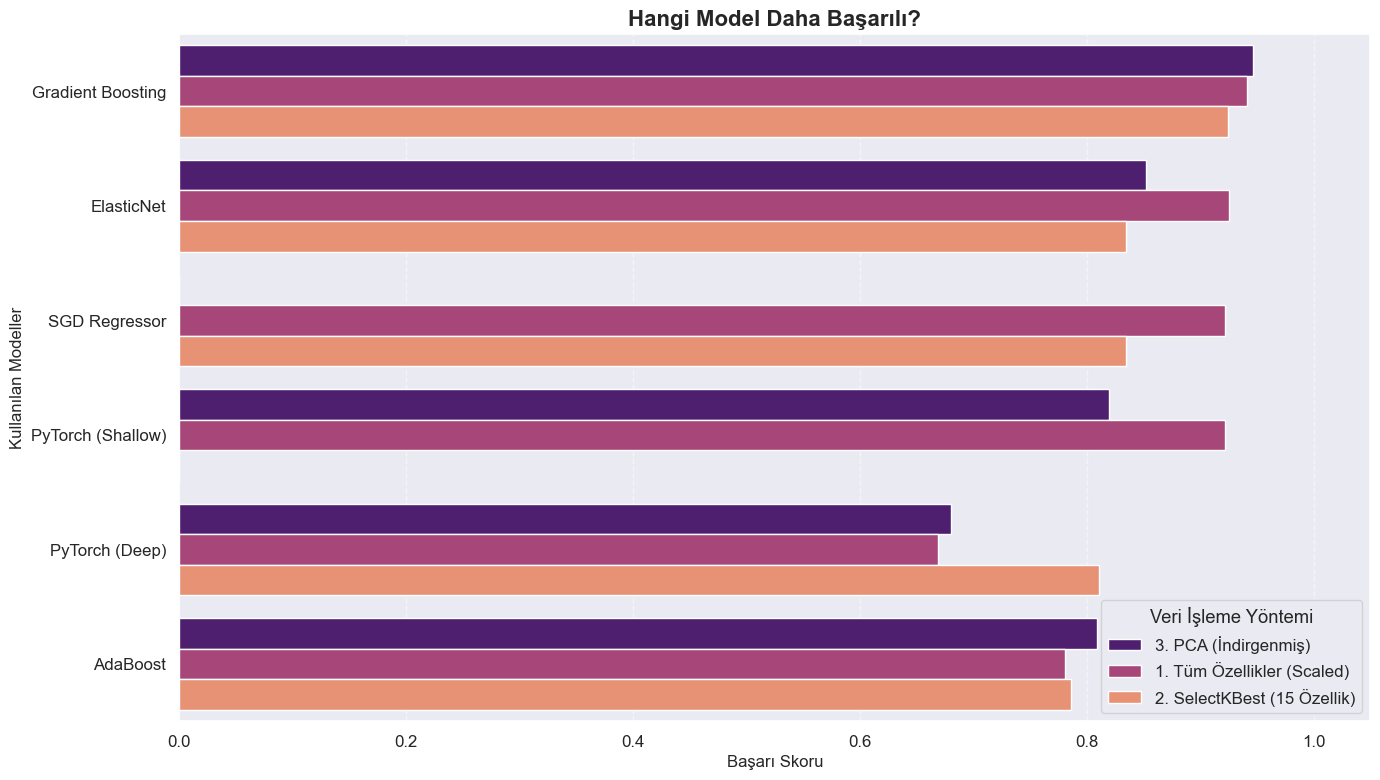

Kazanan: GRADIENT BOOSTING
Kullanılan Yöntem: 3. PCA (İndirgenmiş)
R2 Başarı Skoru : 0.94680
Ortalama Hata   : 1469.58 (Tahminlerimiz ortalama bu kadar sapıyor)
Parametreler    : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [14]:
print("tüm modeller karşılaştırma")

# diğer modelleri ve  ve yapay sinir ağı sonuçlarını tek bir havuzda topluyorum
# (yukarıdaki hücrelerde 'sklearn_results' ve 'pytorch_results' listelerini zaten doldurmuştuk)
all_results = sklearn_results + pytorch_results

# 2 veriyi datafreame çevirip düzenliyoruz
df_final = pd.DataFrame(all_results)
df_final_sorted = df_final.sort_values(by="R2 Score", ascending=False).reset_index(drop=True)

# 3 görselleştirme 
plt.figure(figsize=(14, 8))

# bar grafiği (Renklendirmeyi veri seti yöntemine göre yapalım ki hangi yöntemin iyi olduğu görülsün)
sns.barplot(
    data=df_final_sorted, 
    x="R2 Score", 
    y="Model", 
    hue="Yöntem", 
    palette="magma"
)

plt.title("Hangi Model Daha Başarılı?", fontsize=16, fontweight='bold')
plt.xlabel("Başarı Skoru", fontsize=12)
plt.ylabel("Kullanılan Modeller", fontsize=12)
plt.legend(title="Veri İşleme Yöntemi", loc="lower right")
plt.xlim(0, 1.05) # R2 skoru max 1 olabilir, biraz boşluk bırakalım
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# kazananı yazıyorum
best_model = df_final_sorted.iloc[0]

print(f"Kazanan: {best_model['Model'].upper()}")
print(f"Kullanılan Yöntem: {best_model['Yöntem']}")
print(f"R2 Başarı Skoru : {best_model['R2 Score']:.5f}")
print(f"Ortalama Hata   : {best_model['MAE']:.2f} (Tahminlerimiz ortalama bu kadar sapıyor)")
print(f"Parametreler    : {best_model['Optimum Parametre']}")